In [1]:
import numpy as np
import matplotlib.pyplot as plt
from test2 import *

# defines how many atoms will be in row and column
rows, cols = 40, 40
# define the side of triangle
spacing = 1.0
k_f = 0.2
J0 = 1.0

# test
lattice = TriangularLattice(k_f, J0)
lattice.generate_lattice(40,40,0.2)


In [ ]:
T = 0.1
steps, warmup = 1000000, 100000
lattice.monte_carlo_loop(steps,warmup, T)
lattice.acceptance_rate


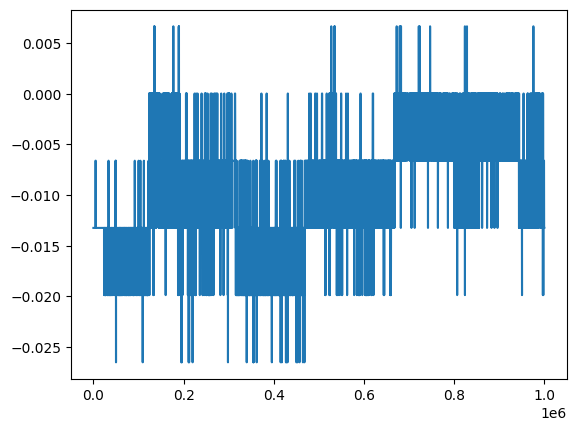

In [130]:
plt.plot(lattice.magnetization)

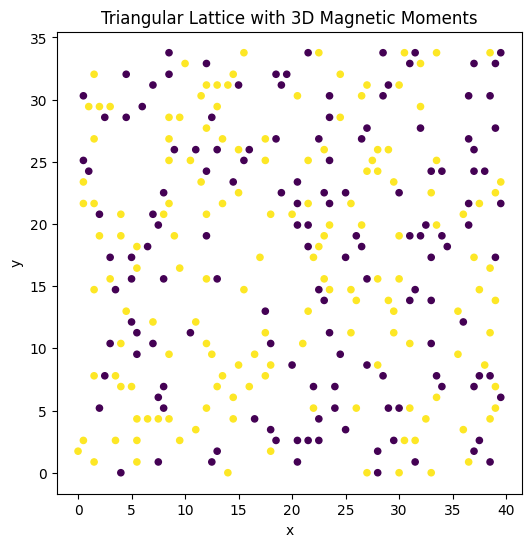

In [2]:

# plots! the system sanity-check
fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(11)
plt.scatter(lattice.lattice_points[:, 0], lattice.lattice_points[:, 1],  s=20, c=lattice.magnetic_moments)
# plt.quiver(lattice.lattice_points[:, 0], lattice.lattice_points[:, 1],
        #   lattice.magnetic_moments[:, 0], lattice.magnetic_moments[:, 1], lattice.magnetic_moments[:, 2],
        #   length=0.5, color='b')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Triangular Lattice with 3D Magnetic Moments")
plt.show()



In [ ]:

# temperatures = np.linspace(0.1, 5.0, 20)

# lattice = TriangularLattice(rows, cols, spacing, k_f, U0)

# magnetizations = []
# for T in temperatures:
#     lattice.run_monte_carlo(steps, T)
#     magnetizations.append(lattice.average_magnetization_x())



# # magnetiyation plot
# plt.figure(figsize=(8, 6))
# plt.plot(temperatures, magnetizations, marker='o', linestyle='-', color='b')
# plt.xlabel("Temperature [T]")
# plt.ylabel("m_x")
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.show()


In [67]:
T = 0.1
steps, warmup = 100000, 10000
lattice.monte_carlo_loop(steps,warmup, T)


In [68]:
lattice.acceptance_rate

0.09317

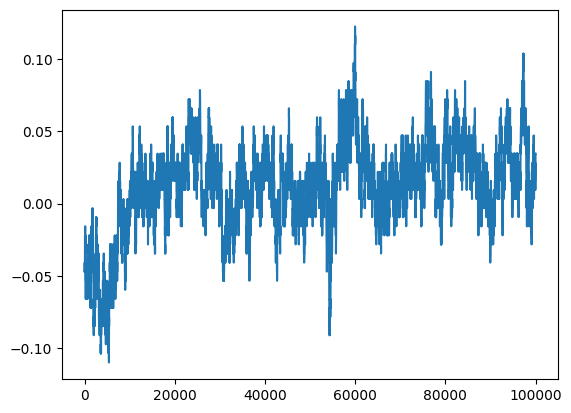

In [69]:
plt.plot(lattice.magnetization)

In [70]:
np.mean(lattice.magnetization)

np.float64(0.011845579937304073)

In [71]:
np.std(lattice.magnetization)

np.float64(0.03084058423434173)

In [72]:
lattice.magnetic_moments

array([-1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1,
        1, -1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1,
        1,  1, -1,  1,  1,  1,  1, -1,  1, -1, -1, -1,  1,  1, -1, -1, -1,
        1,  1, -1,  1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1, -1, -1, -1,
        1, -1, -1, -1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1, -1, -1,  1,
       -1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1, -1, -1, -1,  1,  1, -1,
       -1, -1, -1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1,
        1,  1, -1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1, -1, -1,  1,  1,
        1, -1, -1, -1,  1,  1, -1, -1,  1, -1,  1,  1, -1, -1, -1,  1,  1,
        1,  1,  1, -1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1, -1,  1,
        1, -1, -1, -1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1, -1, -1,
       -1,  1,  1, -1,  1

In [112]:
def rkky_interaction_2d(r,kf=1,J0=1):
    if r == 0:
        return 0
    x = kf * r
    return -J0 * (j0(x) * y0(x) + j1(x) * y1(x))


In [113]:
r_values = np.linspace(0, 15.0, 200)


In [ ]:
res = []
J0_values = np.linspace(-2,2,7) 
for r in r_values:
    for 
    res.append(rkky_interaction_2d(r))

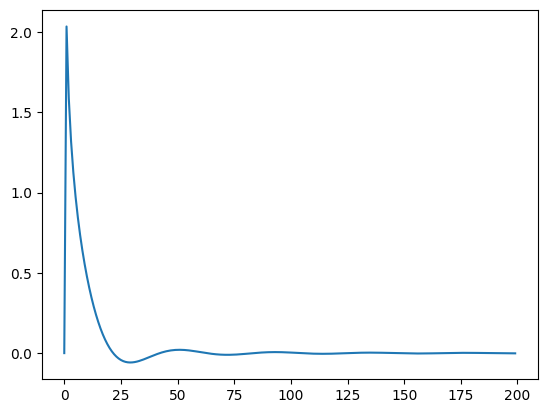

In [115]:
plt.plot(res)

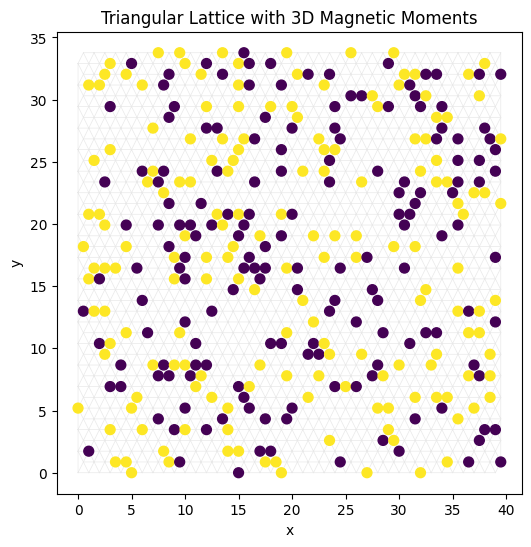

In [2]:
import matplotlib.tri as tri
rows, cols = 40, 40  # Adjust grid size as needed
full_points = []
for i in range(rows):
    for j in range(cols):
        x = j * 1 + (i % 2) * (1 / 2)
        y = i * (1 * np.sqrt(3) / 2)
        full_points.append((x, y))

full_points = np.array(full_points)

triang = tri.Triangulation(full_points[:, 0], full_points[:, 1])

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))

# Plot background triangular mesh
ax.triplot(triang, color="lightgray", alpha=0.5, linewidth=0.5)

# Plot actual atoms with magnetic moments
sc = ax.scatter(lattice.lattice_points[:, 0], lattice.lattice_points[:, 1], s=50, c=lattice.magnetic_moments)

# Formatting
plt.xlabel("x")
plt.ylabel("y")
plt.title("Triangular Lattice with 3D Magnetic Moments")

plt.show()

In [4]:
r, corr = lattice.pair_correlation
plt.plot(r, corr, marker='o')
plt.xlabel("Расстояние r")
plt.ylabel("Усредненная корреляция ⟨Si Sj⟩")
plt.title("Парная корреляционная функция")
plt.show()


AttributeError: 'TriangularLattice' object has no attribute 'pair_correlation'

In [5]:
T = 0.1
steps, warmup = 100, 10
lattice.monte_carlo_loop(steps,warmup, T)
